In [113]:
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [114]:
import langchain
import langchain_community

In [115]:
langchain.__version__

'0.2.6'

In [116]:
langchain_community.__version__

'0.2.6'

In [117]:
import os

In [118]:
from dotenv import load_dotenv

In [119]:
load_dotenv('/home/santhosh/Projects/courses/Pinnacle/.env')

True

In [120]:
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']

# Data

In [121]:
from langchain_core.documents import Document

In [122]:
sentences = [
    "The Milky Way galaxy contains billions of stars, each potentially hosting its own planetary system.",
    "Photosynthesis is a process used by plants to convert light energy into chemical energy.",
    "The principles of supply and demand are fundamental to understanding market economies.",
    "In calculus, the derivative represents the rate of change of a function with respect to a variable.",
    "Quantum mechanics explores the behavior of particles at the smallest scales, where classical physics no longer applies.",
    "Enzymes are biological catalysts that speed up chemical reactions in living organisms.",
    "Game theory is a mathematical framework used for analyzing strategic interactions between rational decision-makers.",
    "The double helix structure of DNA was discovered by Watson and Crick in 1953, revolutionizing biology."
]

In [123]:
categories = ["Astronomy", "Biology", "Economics", "Mathematics", "Physics", "Biochemistry", "Mathematics", "Biology"]

In [124]:
documents = []
for i, sentence in enumerate(sentences):
    documents.append(Document(page_content=sentence, metadata={'source': categories[i]}))

In [125]:
documents

[Document(metadata={'source': 'Astronomy'}, page_content='The Milky Way galaxy contains billions of stars, each potentially hosting its own planetary system.'),
 Document(metadata={'source': 'Biology'}, page_content='Photosynthesis is a process used by plants to convert light energy into chemical energy.'),
 Document(metadata={'source': 'Economics'}, page_content='The principles of supply and demand are fundamental to understanding market economies.'),
 Document(metadata={'source': 'Mathematics'}, page_content='In calculus, the derivative represents the rate of change of a function with respect to a variable.'),
 Document(metadata={'source': 'Physics'}, page_content='Quantum mechanics explores the behavior of particles at the smallest scales, where classical physics no longer applies.'),
 Document(metadata={'source': 'Biochemistry'}, page_content='Enzymes are biological catalysts that speed up chemical reactions in living organisms.'),
 Document(metadata={'source': 'Mathematics'}, page

In [126]:
query = 'Plants use sunlight to create energy through a process called photosynthesis.'

# Embeddings

In [127]:
from langchain_openai import OpenAIEmbeddings

In [128]:
embedding_model = OpenAIEmbeddings(model='text-embedding-3-small', show_progress_bar=True)

In [59]:
embeddings = embedding_model.embed_documents(sentences)

  0%|          | 0/1 [00:00<?, ?it/s]

In [60]:
len(embeddings)

8

In [61]:
len(embeddings[0])

1536

In [62]:
similarities = cosine_similarity(embeddings)

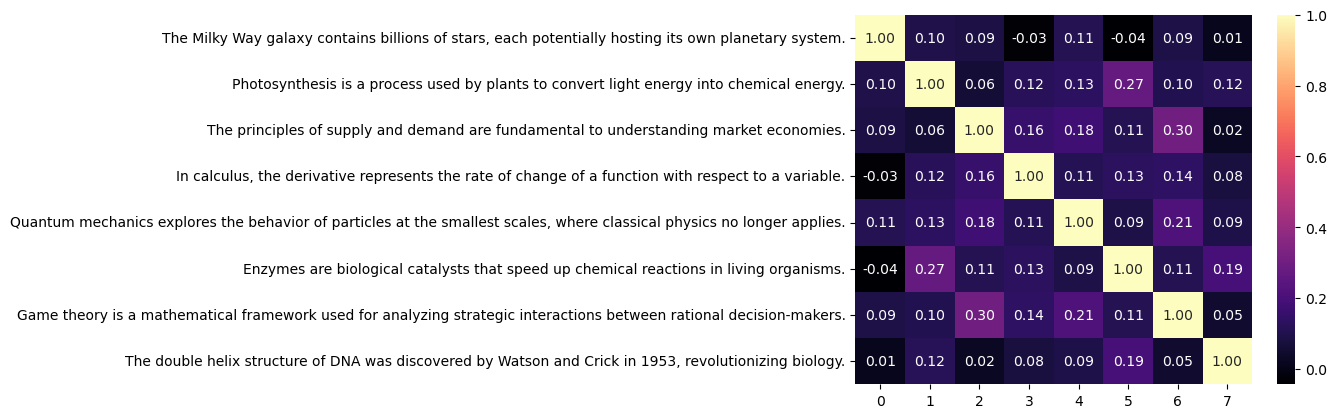

In [66]:
sns.heatmap(similarities, cmap='magma', center=None, annot=True, fmt='.2f', yticklabels=sentences);

In [68]:
query_embedding = embedding_model.embed_query(query)

  0%|          | 0/1 [00:00<?, ?it/s]

In [69]:
query_similarities = cosine_similarity(X=[query_embedding], Y=embeddings)

In [71]:
for i in np.argsort(query_similarities[0])[::-1]:
    print(format(query_similarities[0][i], '.3f'), sentences[i])

0.711 Photosynthesis is a process used by plants to convert light energy into chemical energy.
0.206 Enzymes are biological catalysts that speed up chemical reactions in living organisms.
0.172 The Milky Way galaxy contains billions of stars, each potentially hosting its own planetary system.
0.104 The double helix structure of DNA was discovered by Watson and Crick in 1953, revolutionizing biology.
0.100 Quantum mechanics explores the behavior of particles at the smallest scales, where classical physics no longer applies.
0.098 The principles of supply and demand are fundamental to understanding market economies.
0.067 Game theory is a mathematical framework used for analyzing strategic interactions between rational decision-makers.
0.053 In calculus, the derivative represents the rate of change of a function with respect to a variable.


In [23]:
from langchain_huggingface import HuggingFaceEmbeddings

In [24]:
hf_embedding_model = HuggingFaceEmbeddings(model_name='Snowflake/snowflake-arctic-embed-m')

The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
/home/santhosh/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [25]:
hf_embedding_model = HuggingFaceEmbeddings(model_name='BAAI/bge-base-en-v1.5')

In [27]:
embeddings = hf_embedding_model.embed_documents(sentences)

In [28]:
len(embeddings)

8

In [29]:
len(embeddings[0])

768

In [31]:
similarities = cosine_similarity(embeddings)

<Axes: >

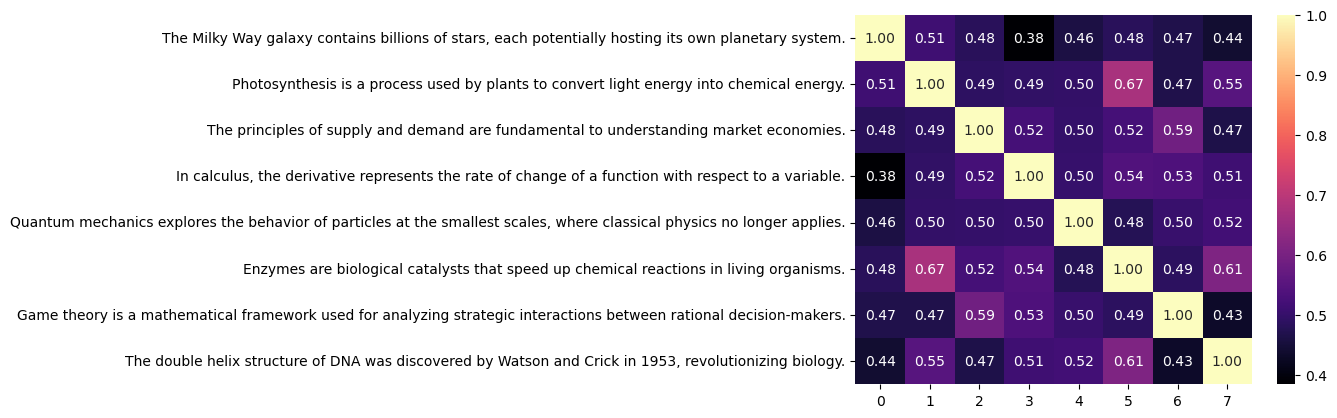

In [32]:
sns.heatmap(similarities, cmap='magma', center=None, annot=True, fmt='.2f', yticklabels=sentences)

In [34]:
query_embedding = hf_embedding_model.embed_query(query)

In [35]:
similarities = cosine_similarity(X=[query_embedding], Y=embeddings)

In [36]:
for i in np.argsort(similarities[0])[::-1][:3]:
    print(format(similarities[0][i], '.3f'), sentences[i])

0.916 Photosynthesis is a process used by plants to convert light energy into chemical energy.
0.630 Enzymes are biological catalysts that speed up chemical reactions in living organisms.
0.565 The Milky Way galaxy contains billions of stars, each potentially hosting its own planetary system.


# Vector Store

In [129]:
import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [130]:
from langchain_chroma import Chroma

In [17]:
embedding_function = OpenAIEmbeddingFunction(api_key=os.environ.get('OPENAI_API_KEY'), model_name='text-embedding-3-small')

In [57]:
client = chromadb.PersistentClient('./sentence_db')

In [58]:
collection = client.get_or_create_collection('example', metadata={'hnsw:space': 'cosine'}, embedding_function=embedding_function)

In [59]:
ids = [str(i) for i in range(len(sentences))]

In [60]:
collection.add(ids=ids, documents=sentences)

In [61]:
client.get_collection(name='example').count()

8

In [62]:
collection.query(query_texts=query, n_results=3)

{'ids': [['1', '5', '0']],
 'distances': [[0.28877742665268513, 0.7935418690428222, 0.8284312808132823]],
 'metadatas': [[None, None, None]],
 'embeddings': None,
 'documents': [['Photosynthesis is a process used by plants to convert light energy into chemical energy.',
   'Enzymes are biological catalysts that speed up chemical reactions in living organisms.',
   'The Milky Way galaxy contains billions of stars, each potentially hosting its own planetary system.']],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

In [63]:
# client.delete_collection(name='example')

In [64]:
db = Chroma(client=client, collection_name='example', embedding_function=embedding_model)

In [65]:
db.similarity_search_with_relevance_scores(query=query, k=3)

  0%|          | 0/1 [00:00<?, ?it/s]

[(Document(page_content='Photosynthesis is a process used by plants to convert light energy into chemical energy.'),
  0.7112225733473149),
 (Document(page_content='Enzymes are biological catalysts that speed up chemical reactions in living organisms.'),
  0.2064581309571778),
 (Document(page_content='The Milky Way galaxy contains billions of stars, each potentially hosting its own planetary system.'),
  0.17156871918671768)]

In [162]:
db = Chroma.from_texts(texts=sentences, embedding=embedding_model, relevance_score_fn=lambda distance: 1.0 - distance / 2,
                       collection_name='sentences', collection_metadata={"hnsw:space": "l2"})

  0%|          | 0/1 [00:00<?, ?it/s]

In [79]:
db = Chroma.from_texts(texts=sentences, embedding=embedding_model, persist_directory='./sentences_db',
                       collection_name='example', collection_metadata={"hnsw:space": "cosine"})

  0%|          | 0/1 [00:00<?, ?it/s]

In [80]:
ids = db.get()['ids']

In [81]:
db.get(include=['embeddings', 'metadatas', 'documents'])['documents']

['The Milky Way galaxy contains billions of stars, each potentially hosting its own planetary system.',
 'In calculus, the derivative represents the rate of change of a function with respect to a variable.',
 'Enzymes are biological catalysts that speed up chemical reactions in living organisms.',
 'Game theory is a mathematical framework used for analyzing strategic interactions between rational decision-makers.',
 'The double helix structure of DNA was discovered by Watson and Crick in 1953, revolutionizing biology.',
 'Quantum mechanics explores the behavior of particles at the smallest scales, where classical physics no longer applies.',
 'The principles of supply and demand are fundamental to understanding market economies.',
 'Photosynthesis is a process used by plants to convert light energy into chemical energy.']

In [173]:
db._collection.delete(ids=ids)

In [78]:
db.delete_collection()

In [82]:
db.similarity_search_with_score(query=query, k=3)

  0%|          | 0/1 [00:00<?, ?it/s]

[(Document(page_content='Photosynthesis is a process used by plants to convert light energy into chemical energy.'),
  0.28877742665268513),
 (Document(page_content='Enzymes are biological catalysts that speed up chemical reactions in living organisms.'),
  0.7935418690428222),
 (Document(page_content='The Milky Way galaxy contains billions of stars, each potentially hosting its own planetary system.'),
  0.8284312808132823)]

In [83]:
db.similarity_search_with_relevance_scores(query=query, k=3)

  0%|          | 0/1 [00:00<?, ?it/s]

[(Document(page_content='Photosynthesis is a process used by plants to convert light energy into chemical energy.'),
  0.7112225733473149),
 (Document(page_content='Enzymes are biological catalysts that speed up chemical reactions in living organisms.'),
  0.2064581309571778),
 (Document(page_content='The Milky Way galaxy contains billions of stars, each potentially hosting its own planetary system.'),
  0.17156871918671768)]

In [22]:
db2 = Chroma(persist_directory="./sentences_db/", collection_name='example', embedding_function=embedding_model)

In [23]:
db2.similarity_search_with_score(query=query, k=3)

  0%|          | 0/1 [00:00<?, ?it/s]

[(Document(page_content='Photosynthesis is a process used by plants to convert light energy into chemical energy.'),
  0.2888347382510862),
 (Document(page_content='Enzymes are biological catalysts that speed up chemical reactions in living organisms.'),
  0.7934994776381676),
 (Document(page_content='The Milky Way galaxy contains billions of stars, each potentially hosting its own planetary system.'),
  0.8285197505142937)]

In [24]:
db2.add_texts(texts=sentences)

  0%|          | 0/1 [00:00<?, ?it/s]

['33ae0404-a108-4d9a-ba50-479ab7cdeb95',
 'c6fbd226-f26d-43ce-bd40-cc9497bc7564',
 '5d6bb44d-794e-44be-ac5d-33ad9a8a6b1b',
 'ab870a1f-a0ac-4053-8141-d8f2c0d928bd',
 '259b3740-c9d9-48e4-b06a-27c0eecece41',
 '24493d6e-926e-49bb-a636-b841f6529e0e',
 '64d8b2bc-7254-41cb-ad79-38ffccfbc212',
 'd57ca459-2c52-4bca-825a-c1fa34106fcc']

In [27]:
db2.get(include=['embeddings', 'metadatas', 'documents'])['documents']

['In calculus, the derivative represents the rate of change of a function with respect to a variable.',
 'Enzymes are biological catalysts that speed up chemical reactions in living organisms.',
 'Quantum mechanics explores the behavior of particles at the smallest scales, where classical physics no longer applies.',
 'The Milky Way galaxy contains billions of stars, each potentially hosting its own planetary system.',
 'The Milky Way galaxy contains billions of stars, each potentially hosting its own planetary system.',
 'Photosynthesis is a process used by plants to convert light energy into chemical energy.',
 'The principles of supply and demand are fundamental to understanding market economies.',
 'Game theory is a mathematical framework used for analyzing strategic interactions between rational decision-makers.',
 'Game theory is a mathematical framework used for analyzing strategic interactions between rational decision-makers.',
 'Enzymes are biological catalysts that speed up 

# Indexing

In [157]:
from langchain.indexes import SQLRecordManager, index

In [158]:
documents

[Document(metadata={'source': 'Astronomy'}, page_content='The Milky Way galaxy contains billions of stars, each potentially hosting its own planetary system.'),
 Document(metadata={'source': 'Biology'}, page_content='Photosynthesis is a process used by plants to convert light energy into chemical energy.'),
 Document(metadata={'source': 'Economics'}, page_content='The principles of supply and demand are fundamental to understanding market economies.'),
 Document(metadata={'source': 'Mathematics'}, page_content='In calculus, the derivative represents the rate of change of a function with respect to a variable.'),
 Document(metadata={'source': 'Physics'}, page_content='Quantum mechanics explores the behavior of particles at the smallest scales, where classical physics no longer applies.'),
 Document(metadata={'source': 'Biochemistry'}, page_content='Enzymes are biological catalysts that speed up chemical reactions in living organisms.'),
 Document(metadata={'source': 'Mathematics'}, page

In [272]:
db.delete_collection()

In [273]:
db = Chroma(persist_directory='./sentence_db', collection_name='example', 
            embedding_function=embedding_model, collection_metadata={"hnsw:space": "cosine"})

In [274]:
db.get()

{'ids': [],
 'embeddings': None,
 'metadatas': [],
 'documents': [],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents']}

In [275]:
namespace = f"db/example"

In [276]:
record_manager = SQLRecordManager(namespace, db_url="sqlite:///record_manager.sql")

In [277]:
record_manager.create_schema()

In [278]:
record_manager.list_keys()

[]

In [249]:
index(docs_source=documents, record_manager=record_manager, vector_store=db, cleanup='incremental' ,source_id_key='source')

  0%|          | 0/1 [00:00<?, ?it/s]

{'num_added': 8, 'num_updated': 0, 'num_skipped': 0, 'num_deleted': 0}

In [279]:
index(docs_source=documents, record_manager=record_manager, vector_store=db, cleanup=None ,source_id_key='source')

  0%|          | 0/1 [00:00<?, ?it/s]

{'num_added': 8, 'num_updated': 0, 'num_skipped': 0, 'num_deleted': 0}

In [280]:
db.get()

{'ids': ['1d6f9cc0-bb44-5de5-bd48-9bd3e00b1195',
  '26919da7-b200-5562-b144-863c394fb31e',
  '2f9a7e67-4f45-5ae0-9f5a-f14237c58ce4',
  '3d588f76-2c58-5e83-8945-1d2d347ce470',
  '62846b35-30e9-5f5a-bb3a-745957e69c37',
  'a2506367-f726-5630-b2b3-26915b03b9f4',
  'bfc6d684-19cb-5c87-aa00-cf770b957114',
  'e2d6fcc6-f7d6-57a3-a890-e3e851026dac'],
 'embeddings': None,
 'metadatas': [{'source': 'Biology'},
  {'source': 'Biology'},
  {'source': 'Physics'},
  {'source': 'Astronomy'},
  {'source': 'Biochemistry'},
  {'source': 'Mathematics'},
  {'source': 'Mathematics'},
  {'source': 'Economics'}],
 'documents': ['Photosynthesis is a process used by plants to convert light energy into chemical energy.',
  'The double helix structure of DNA was discovered by Watson and Crick in 1953, revolutionizing biology.',
  'Quantum mechanics explores the behavior of particles at the smallest scales, where classical physics no longer applies.',
  'The Milky Way galaxy contains billions of stars, each potenti

In [281]:
index(docs_source=documents, record_manager=record_manager, vector_store=db, cleanup=None)

{'num_added': 0, 'num_updated': 0, 'num_skipped': 8, 'num_deleted': 0}

In [282]:
doc1 = Document(page_content="The human immune system protects the body from infections by identifying and destroying pathogens", 
                metadata={"source": "Biology"})
doc2 = Document(page_content="Genetic mutations can lead to variations in traits, which may be beneficial, neutral, or harmful to an organism", 
                metadata={"source": "Biology"})

In [283]:
index(docs_source=[doc1, doc2], record_manager=record_manager, vector_store=db, cleanup='incremental', source_id_key='source')

  0%|          | 0/1 [00:00<?, ?it/s]

{'num_added': 2, 'num_updated': 0, 'num_skipped': 0, 'num_deleted': 0}

In [284]:
db.get()

{'ids': ['1d6f9cc0-bb44-5de5-bd48-9bd3e00b1195',
  '26919da7-b200-5562-b144-863c394fb31e',
  '2f9a7e67-4f45-5ae0-9f5a-f14237c58ce4',
  '3d588f76-2c58-5e83-8945-1d2d347ce470',
  '62846b35-30e9-5f5a-bb3a-745957e69c37',
  '9ab301fa-0303-50d5-8166-0a2aaf2e5df7',
  'a2506367-f726-5630-b2b3-26915b03b9f4',
  'bfc6d684-19cb-5c87-aa00-cf770b957114',
  'e2d6fcc6-f7d6-57a3-a890-e3e851026dac',
  'f95b9f7b-1fc4-5888-bb64-6a99d770ae4f'],
 'embeddings': None,
 'metadatas': [{'source': 'Biology'},
  {'source': 'Biology'},
  {'source': 'Physics'},
  {'source': 'Astronomy'},
  {'source': 'Biochemistry'},
  {'source': 'Biology'},
  {'source': 'Mathematics'},
  {'source': 'Mathematics'},
  {'source': 'Economics'},
  {'source': 'Biology'}],
 'documents': ['Photosynthesis is a process used by plants to convert light energy into chemical energy.',
  'The double helix structure of DNA was discovered by Watson and Crick in 1953, revolutionizing biology.',
  'Quantum mechanics explores the behavior of particles

In [173]:
doc1 = Document(page_content="The human immune system protects the body from infections by identifying and destroying pathogens", 
                metadata={"source": "Biology"})
doc2 = Document(page_content="Genetic mutations can lead to variations in traits, which may be beneficial, neutral, or harmful", 
                metadata={"source": "Genetics"})

In [285]:
doc1 = Document(page_content="The human immune system protects the body from infections by identifying and destroying pathogens", 
                metadata={"source": "Biology"})
doc2 = Document(page_content="Genetic mutations can lead to variations in traits, which may be beneficial, neutral, or harmful", 
                metadata={"source": "Biology"})

In [239]:
index(docs_source=[doc1, doc2], record_manager=record_manager, vector_store=db, cleanup='incremental', source_id_key='source')

  0%|          | 0/1 [00:00<?, ?it/s]

{'num_added': 1, 'num_updated': 0, 'num_skipped': 1, 'num_deleted': 0}

In [240]:
db.get()

{'ids': ['2f9a7e67-4f45-5ae0-9f5a-f14237c58ce4',
  '3200e72e-7836-53ad-a2c1-a62d20405df2',
  '3d588f76-2c58-5e83-8945-1d2d347ce470',
  '62846b35-30e9-5f5a-bb3a-745957e69c37',
  'a2506367-f726-5630-b2b3-26915b03b9f4',
  'bfc6d684-19cb-5c87-aa00-cf770b957114',
  'e2d6fcc6-f7d6-57a3-a890-e3e851026dac',
  'f95b9f7b-1fc4-5888-bb64-6a99d770ae4f'],
 'embeddings': None,
 'metadatas': [{'source': 'Physics'},
  {'source': 'Biology'},
  {'source': 'Astronomy'},
  {'source': 'Biochemistry'},
  {'source': 'Mathematics'},
  {'source': 'Mathematics'},
  {'source': 'Economics'},
  {'source': 'Biology'}],
 'documents': ['Quantum mechanics explores the behavior of particles at the smallest scales, where classical physics no longer applies.',
  'Genetic mutations can lead to variations in traits, which may be beneficial, neutral, or harmful',
  'The Milky Way galaxy contains billions of stars, each potentially hosting its own planetary system.',
  'Enzymes are biological catalysts that speed up chemical 

In [155]:
db.get()

{'ids': ['1d6f9cc0-bb44-5de5-bd48-9bd3e00b1195',
  '26919da7-b200-5562-b144-863c394fb31e',
  '2f9a7e67-4f45-5ae0-9f5a-f14237c58ce4',
  '3200e72e-7836-53ad-a2c1-a62d20405df2',
  '3d588f76-2c58-5e83-8945-1d2d347ce470',
  '62846b35-30e9-5f5a-bb3a-745957e69c37',
  'a2506367-f726-5630-b2b3-26915b03b9f4',
  'bfc6d684-19cb-5c87-aa00-cf770b957114',
  'e2d6fcc6-f7d6-57a3-a890-e3e851026dac'],
 'embeddings': None,
 'metadatas': [{'source': 'Biology'},
  {'source': 'Biology'},
  {'source': 'Physics'},
  {'source': 'Biology'},
  {'source': 'Astronomy'},
  {'source': 'Biochemistry'},
  {'source': 'Mathematics'},
  {'source': 'Mathematics'},
  {'source': 'Economics'}],
 'documents': ['Photosynthesis is a process used by plants to convert light energy into chemical energy.',
  'The double helix structure of DNA was discovered by Watson and Crick in 1953, revolutionizing biology.',
  'Quantum mechanics explores the behavior of particles at the smallest scales, where classical physics no longer applies.

In [156]:
index([], record_manager=record_manager, vector_store=db, cleanup="full", source_id_key="source")

{'num_added': 0, 'num_updated': 0, 'num_skipped': 0, 'num_deleted': 9}